In [ ]:
!pip install onnxruntime
!pip install rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install rembg onnxruntime

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from rembg import remove
from google.colab import drive

drive.mount('/content/drive')

# =========================================================
# 1. Path Input dan Output
# =========================================================
input_root = "/content/drive/MyDrive/Dataset parkiran"
output_folder = "/content/drive/MyDrive/Dataset parkiran/output_final"

os.makedirs(output_folder, exist_ok=True)
print("Folder output siap:", output_folder)

# =========================================================
# 2. Ambil SEMUA file gambar termasuk subfolder
# =========================================================
valid_ext = (".jpg", ".jpeg", ".png", ".heic")

image_files = []
for root, dirs, files in os.walk(input_root):
    for f in files:
        if f.lower().endswith(valid_ext):
            image_files.append(os.path.join(root, f))

print(f"Total gambar ditemukan: {len(image_files)}")

# =========================================================
# 3. Loop untuk memproses semua gambar
# =========================================================
for input_path in image_files:

    filename = os.path.basename(input_path)
    print("Memproses:", input_path)

    # =====================================================
    # Hapus background → dipakai sementara (tidak disimpan)
    # =====================================================
    try:
        with open(input_path, "rb") as inp:
            nobg_bytes = remove(inp.read())
    except Exception as e:
        print("Gagal remove BG:", e)
        continue

    # Convert hasil remove bg ke array
    nparr = np.frombuffer(nobg_bytes, np.uint8)
    img_nobg = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    if img_nobg is None:
        print("❌ Gambar HEIC mungkin tidak terbaca, melewati:", filename)
        continue

    # Resize
    img_original = cv2.imread(input_path)
    if img_original is None:
        print("❌ Gambar tidak bisa dibaca:", filename)
        continue

    img_original = cv2.resize(img_original, (960, 540))
    img_nobg = cv2.resize(img_nobg, (960, 540))

    # =====================================================
    # Pra-pemrosesan
    # =====================================================
    gray = cv2.cvtColor(img_nobg, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # =====================================================
    # Threshold
    # =====================================================
    _, thresh = cv2.threshold(gray_blur, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # =====================================================
    # Morfologi
    # =====================================================
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=1)

    # =====================================================
    # Distance Transform
    # =====================================================
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform,
                               0.3 * dist_transform.max(),
                               255, 0)
    sure_fg = np.uint8(sure_fg)

    # =====================================================
    # ROI Parkir
    # =====================================================
    h, w = opening.shape
    roi_y_start = int(h * 0.35)
    roi_motor = sure_fg[roi_y_start:h, :]

    # =====================================================
    # Deteksi Motor / Kontur
    # =====================================================
    contours, _ = cv2.findContours(roi_motor, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    motor_boxes = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 300 < area < 250000:        # aturan area
            x, y, wb, hb = cv2.boundingRect(cnt)
            motor_boxes.append((x, y + roi_y_start, wb, hb))

    # =====================================================
    # Slot Parkir (4 slot)
    # =====================================================
    slot_count = 4
    slot_width = w // slot_count

    output_grid = img_original.copy()

    for i in range(slot_count):
        sx = i * slot_width
        sy = roi_y_start
        ex = sx + slot_width
        ey = h

        occupied = False
        for (mx, my, mw, mh) in motor_boxes:
            if mx < ex and mx + mw > sx:  # overlap slot
                occupied = True
                break

        color = (0, 0, 255) if occupied else (0, 255, 0)
        status = "Occupied" if occupied else "Empty"

        cv2.rectangle(output_grid, (sx, sy), (ex, ey), color, 3)
        cv2.putText(output_grid, status, (sx + 5, sy + 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # =====================================================
    # 10. Simpan hasil akhir ke satu folder
    # =====================================================
    save_path = os.path.join(output_folder, f"slot_{filename}.jpg")
    cv2.imwrite(save_path, output_grid)

    print("✔ Hasil akhir disimpan ke:", save_path)

print("\nSelesai memproses semua gambar!")

Mounted at /content/drive
Folder output siap: /content/drive/MyDrive/Dataset parkiran/output_final
Total gambar ditemukan: 0

Selesai memproses semua gambar!


Saving Parkiran (24).jpg to Parkiran (24).jpg
Gambar digunakan: Parkiran (24).jpg


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 200GB/s]


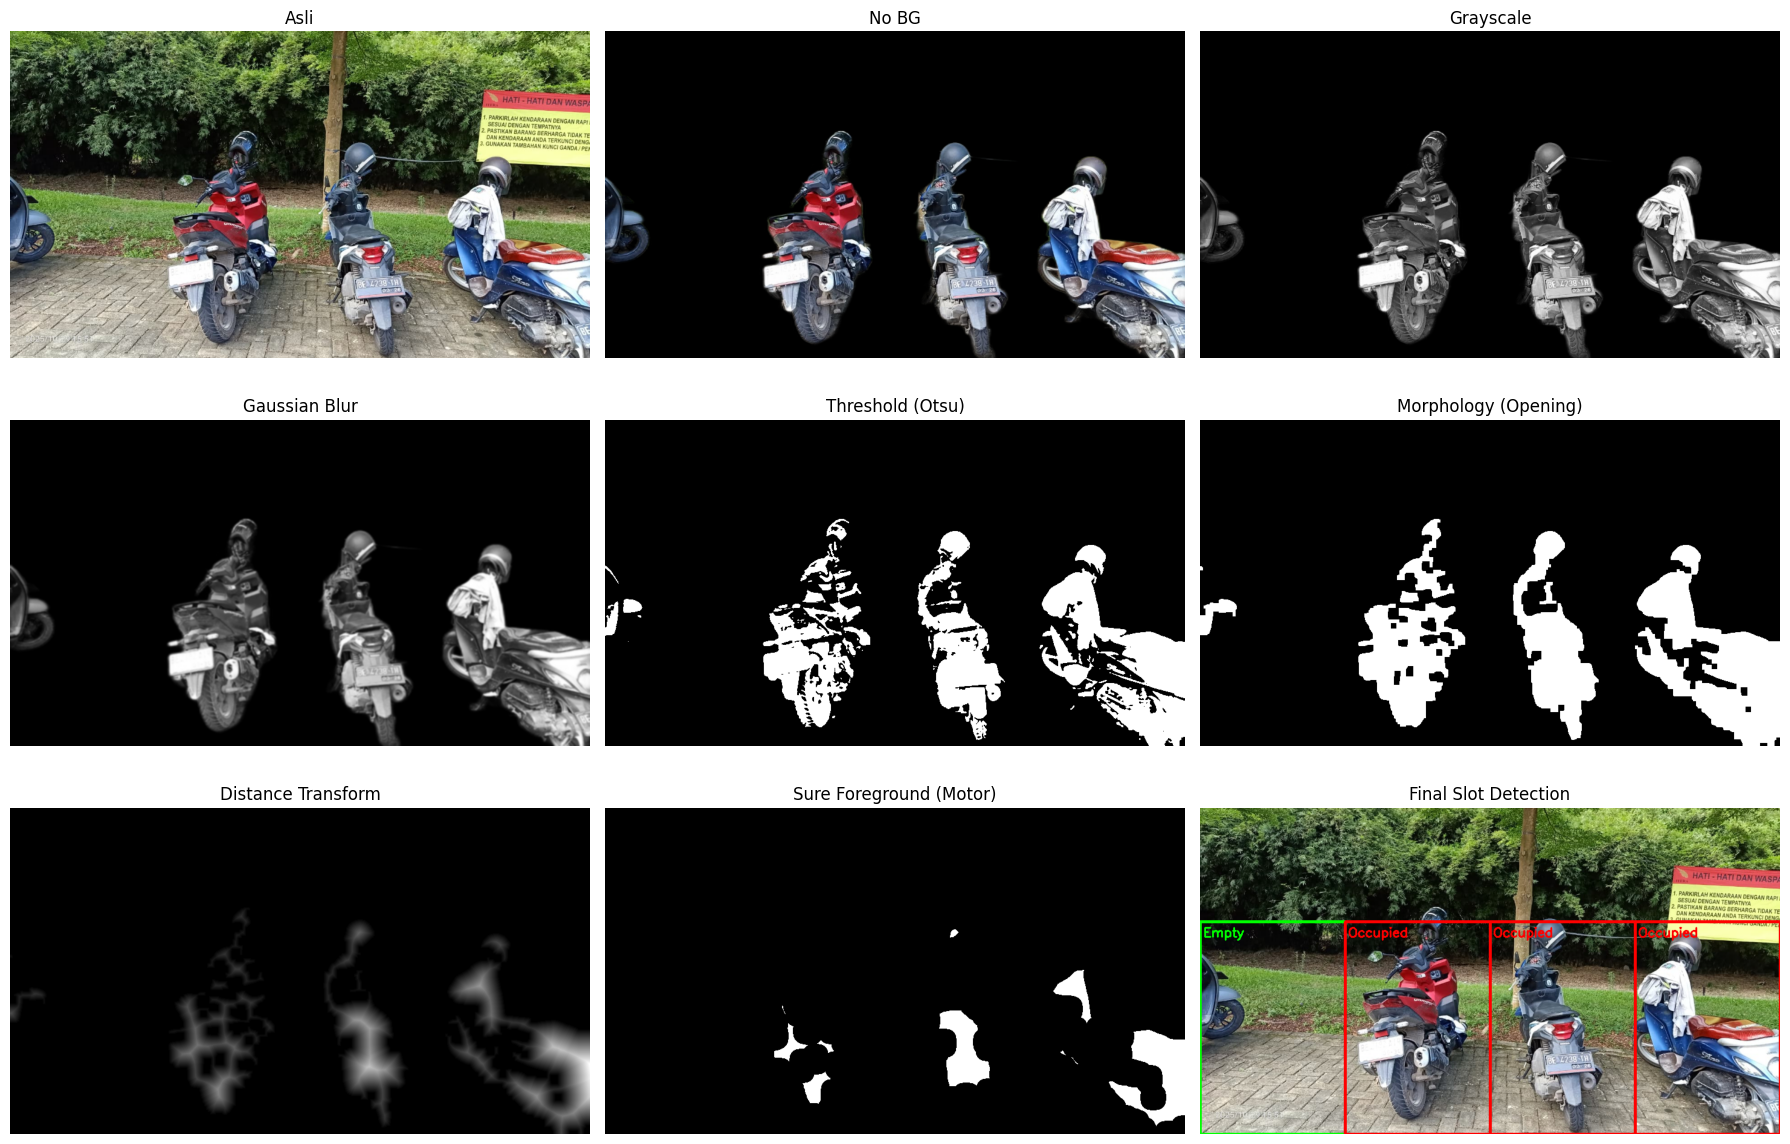

Slot 1: Empty
Slot 2: Occupied
Slot 3: Occupied
Slot 4: Occupied


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from rembg import remove

# =========================================================
# 1. Upload Gambar
# =========================================================
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"Gambar digunakan: {filename}")

# --- 2. Hapus background otomatis ---
from rembg import remove
with open(filename, "rb") as inp:
    result = remove(inp.read())
with open("no_bg.png", "wb") as out:
    out.write(result)

# =========================================================
# 2. Load & Resize Gambar
# =========================================================
img_original = cv2.imread(filename)        # gambar asli
img_original = cv2.resize(img_original, (960, 540))

img_nobg = cv2.imread("no_bg.png")         # gambar tanpa background
img_nobg = cv2.resize(img_nobg, (960, 540))

# =========================================================
# 3. Pra-pemrosesan
# =========================================================
gray = cv2.cvtColor(img_nobg, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

# =========================================================
# 4. Threshold
# =========================================================
_, thresh = cv2.threshold(
    gray_blur, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# =========================================================
# 5. Morfologi
# =========================================================
kernel = np.ones((5, 5), np.uint8)

closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=1)

# =========================================================
# 6. Distance Transform
# =========================================================
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
dist_norm = cv2.normalize(dist_transform, None, 0, 1.0, cv2.NORM_MINMAX)

_, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# =========================================================
# 7. Ambil area parkir (ROI)
# =========================================================
h, w = opening.shape
roi_y_start = int(h * 0.35)
roi_motor = sure_fg[roi_y_start:h, :]

# =========================================================
# 8. Deteksi Kontur Motor
# =========================================================
contours, _ = cv2.findContours(roi_motor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

motor_boxes = []

for cnt in contours:
    area = cv2.contourArea(cnt)
    if 500 < area < 200000:
        x, y, wb, hb = cv2.boundingRect(cnt)
        motor_boxes.append((x, y + roi_y_start, wb, hb))

# =========================================================
# 9. Slot Parkir (4 slot otomatis)
# =========================================================
slot_count = 4
slot_width = w // slot_count

output_grid = img_original.copy()    # ← FINAL memakai gambar asli
slot_results = []

for i in range(slot_count):
    sx = i * slot_width
    sy = roi_y_start
    ex = sx + slot_width
    ey = h

    # Cek apakah ada motor dalam slot ini
    occupied = False
    for (mx, my, mw, mh) in motor_boxes:
        if mx < ex and mx + mw > sx:
            occupied = True
            break

    color = (0, 0, 255) if occupied else (0, 255, 0)
    status = "Occupied" if occupied else "Empty"
    slot_results.append(status)

    cv2.rectangle(output_grid, (sx, sy), (ex, ey), color, 3)
    cv2.putText(output_grid, status, (sx + 5, sy + 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

# =========================================================
# 10. Visualisasi Semua Tahap
# =========================================================
titles = [
    "Asli",
    "No BG",
    "Grayscale",
    "Gaussian Blur",
    "Threshold (Otsu)",
    "Morphology (Opening)",
    "Distance Transform",
    "Sure Foreground (Motor)",
    "Final Slot Detection"
]

images = [
    img_original,
    img_nobg,
    gray,
    gray_blur,
    thresh,
    opening,
    dist_norm,
    sure_fg,
    output_grid
]

plt.figure(figsize=(18, 12))
for i in range(len(images)):
    plt.subplot(3, 3, i + 1)
    if len(images[i].shape) == 2:
        plt.imshow(images[i], cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

# =========================================================
# 11. Print hasil slot
# =========================================================
for idx, res in enumerate(slot_results):
    print(f"Slot {idx+1}: {res}")